# Extract data from DrugBank

Purpose of this notebook is to extract and format Drug data for subsequent model annotation.

## Notebook Requirements:
*  Model genes **must** have UniProt annotations stored in the `object.annotation`. Key must be `"uniprot"` and values are UniProtKB identifiers seperated by semicolons. 

## DRUGBANK ONLINE
To utilize this notebook: 

1. Go to [DrugBank database](https://go.drugbank.com/releases/latest) and create an account.
2. Follow the instructions to obtain a free academic license.
3. Download and unzip the database file `"drugbank_all_full_database.xml.zip"`.
4. Rename the file `"full database.xml"` to `"drugbank_all_full_database.xml"`.
5. Remember clear out any personal account information and ensure the downloaded DrugBank file remains local!

The functions `download_database_DrugBank` takes a given username and a password and downloads the data, taking care to change the filename in the process.

Fields for the DrugBank XML schema are found [here](https://docs.drugbank.com/xml/#introduction).

### Citations
Wishart DS, Feunang YD, Guo AC, Lo EJ, Marcu A, Grant JR, Sajed T, Johnson D, Li C, Sayeeda Z, Assempour N, Iynkkaran I, Liu Y, Maciejewski A, Gale N, Wilson A, Chin L, Cummings R, Le D, Pon A, Knox C, Wilson M. DrugBank 5.0: a major update to the DrugBank database for 2018. Nucleic Acids Res. 2017 Nov 8. doi: 10.1093/nar/gkx1037.

## Setup
### Import packages

In [1]:
from warnings import warn
import pandas as pd
from collections import defaultdict
from xml.etree import ElementTree
import matplotlib.pyplot as plt

from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    ROOT_PATH,
    INTERIM_PATH,
    DATABASE_PATH,
    ANNOTATION_PATH,
    get_annotation_df,
    read_rbc_model,
    check_database_version_online,
    check_version,
    show_versions,
    build_string,
    split_string,
    compare_tables,
    visualize_comparison,
    explode_column,
)
from rbc_gem_utils.database.drugbank import (
    DRUGBANK_NS,
    DRUGBANK_VERSION_EXPECTED,
    DRUGBANK_PATH,
    DRUGBANK_DB_TAG,
    DRUGBANK_PATHWAY_ELEMENTS,
    strip_ns_DrugBank,
    get_version_DrugBank,
    download_database_DrugBank,
)

from rbc_gem_utils.util import strip_plural, has_value_type

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Check DrugBank version
If the version does not match the expected version, it is because database has been updated since the last time this code was utilized. 
### Expected DrugBank version: 5.1.12
* Last release utilized: [5.1.12](https://go.drugbank.com/releases) published on **2024-03-14**
* Version in the DrugBank file is formatted as {major}.{minor}

In [2]:
if not check_database_version_online(DRUGBANK_DB_TAG):
    warn(
        "Online version of database has been updated since the last time notebook was used."
    )

version = get_version_DrugBank()
if check_version(version, DRUGBANK_VERSION_EXPECTED, verbose=True):
    database_dirpath = f"{ROOT_PATH}{DATABASE_PATH}{DRUGBANK_PATH}"
    annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"
else:
    database_dirpath = f"{ROOT_PATH}{INTERIM_PATH}{DRUGBANK_PATH}"
    annotation_dirpath = f"{ROOT_PATH}{INTERIM_PATH}"
    version = DRUGBANK_VERSION_EXPECTED

Current and expected versions match.


#### Download new files and update database
If an argument is not provided (`arg=None`), its default value for the repository used. 
Username and password must be provided for this function, be sure to remove personal information after use!

In [3]:
download = False
if download:
    # Download data
    download_database_DrugBank(
        username="USERNAME",
        password="PASSWORD",
        database_dirpath=database_dirpath,
        version=version,
    )
filepath = f"{database_dirpath}/drugbank_all_full_database.xml"

## Load RBC-GEM model

In [4]:
model = read_rbc_model(filetype="xml")
model

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-28


Name,RBC_GEM
Memory address,14f250550
Number of metabolites,2057
Number of reactions,3030
Number of genes,779
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


In [5]:
annotation_type = "genes"
annotation_cols = ["uniprot", "drugbank"]
mapping_key = "uniprot"

df_model_mappings = (
    get_annotation_df(model.genes, annotation_cols)
    .rename({"id": annotation_type}, axis=1)
    .dropna(subset=[mapping_key])
)

for col in df_model_mappings.columns:
    df_model_mappings = explode_column(df_model_mappings, name=col, sep=";")
df_model_mappings = df_model_mappings.sort_values(annotation_type)

print(df_model_mappings.nunique(dropna=True))
df_model_mappings = df_model_mappings.reset_index(drop=True)

uniprot_ids = set(df_model_mappings["uniprot"].dropna().unique())

df_model_mappings

genes        779
uniprot      779
drugbank    2244
dtype: int64


,genes,uniprot,drugbank
0,A4GALT,Q9NPC4,NaN
1,AARS1,P49588,DB00160
2,AASDHPPT,Q9NRN7,NaN
3,ABCA1,O95477,DB00675
4,ABCA1,O95477,DB00163
...,...,...,...
4264,YES1,P07947,NaN
4265,ZDHHC2,Q9UIJ5,NaN
4266,ZDHHC20,Q5W0Z9,NaN
4267,ZDHHC3,Q9NYG2,NaN


## Set notebook options

In [6]:
# Compare to/Overwrite previous files
compare_figsize = (5, 5)
compare = True
display_nunique = True
overwrite = True
print_footer_notes = False
db_tag = DRUGBANK_DB_TAG

#### Get query IDs

In [7]:
print(f"Mapping key: {mapping_key}")
query_ids = df_model_mappings[mapping_key].dropna().unique()
assert len(set(query_ids)) == len(query_ids), "Duplicate IDs in list to query"
model_search_mapping = df_model_mappings.set_index(annotation_type)[
    mapping_key
].to_dict()
print(f"Number of model genes associated with query: {len(model_search_mapping)}")
print(f"Number of unique IDs to query: {len(query_ids)}")
df_model_mappings[[annotation_type, mapping_key]].drop_duplicates()

Mapping key: uniprot
Number of model genes associated with query: 779
Number of unique IDs to query: 779


,genes,uniprot
0,A4GALT,Q9NPC4
1,AARS1,P49588
2,AASDHPPT,Q9NRN7
3,ABCA1,O95477
9,ABCA7,Q8IZY2
...,...,...
4264,YES1,P07947
4265,ZDHHC2,Q9UIJ5
4266,ZDHHC20,Q5W0Z9
4267,ZDHHC3,Q9NYG2


## Parse DrugBank information into DataFrame

In [8]:
all_drug_dfs = {}
root = ElementTree.parse(f"{database_dirpath}/drugbank_all_full_database.xml").getroot()
root

<Element '{http://www.drugbank.ca}drugbank' at 0x1525574c0>

### Extract proteins

In [9]:
idx = 0
data = defaultdict(dict)
prefix = True
for drug in root:
    drugbank_id = drug.findtext(f"{DRUGBANK_NS}drugbank-id[@primary='true']")
    prefix = f"proteins."
    for ptype in ["targets", "enzymes", "carriers", "transporters"]:
        elements = drug.findall(
            f"{DRUGBANK_NS}{ptype}/{DRUGBANK_NS}{strip_plural(ptype)}"
        )
        for element in elements:
            for subelement in element.findall(f"{DRUGBANK_NS}polypeptide"):
                data[idx].update({f"drugbank-id": drugbank_id, f"{prefix}type": ptype})
                data[idx].update(
                    {
                        f"{prefix}{strip_ns_DrugBank(subelement.tag)}": subelement.text
                        for subelement in element
                        if has_value_type(subelement)
                    }
                )

                # Polypeptide
                key = "polypeptide"
                data[idx].update(
                    {
                        f"{prefix}{key}.uniprot-id": subelement.get("id"),
                        f"{prefix}{key}.source": subelement.get("source"),
                    }
                )
                data[idx].update(
                    {
                        f"{prefix}{key}.{strip_ns_DrugBank(subelem.tag)}": subelem.text
                        for subelem in subelement
                        if has_value_type(subelem)
                    }
                )
                subkey = "pfams"
                data[idx].update(
                    {
                        f"{prefix}{key}.{subkey}": build_string(
                            [
                                subelem.text
                                for subelem in subelement.findall(
                                    f"{DRUGBANK_NS}{subkey}/{DRUGBANK_NS}{strip_plural(subkey)}/{DRUGBANK_NS}identifier"
                                )
                                if has_value_type(subelem)
                            ]
                        )
                    }
                )

                idx += 1

df_drugs_proteins_data = (
    pd.DataFrame.from_dict(data, orient="index")
    .fillna("")
    .drop_duplicates()
    .reset_index(drop=True)
)
df_model_drugs_protein_data = df_drugs_proteins_data[
    df_drugs_proteins_data["proteins.polypeptide.uniprot-id"].isin(uniprot_ids)
]
df_model_drugs_protein_data = df_model_drugs_protein_data.drop_duplicates().reset_index(
    drop=True
)
if display_nunique:
    print(df_model_drugs_protein_data.nunique(dropna=True))
df_model_drugs_protein_data.head()

drugbank-id                                   2303
proteins.type                                    4
proteins.id                                    471
proteins.name                                  471
proteins.organism                                3
proteins.known-action                            3
proteins.polypeptide.uniprot-id                451
proteins.polypeptide.source                      1
proteins.polypeptide.name                      451
proteins.polypeptide.general-function          293
proteins.polypeptide.specific-function         384
proteins.polypeptide.gene-name                 451
proteins.polypeptide.locus                     313
proteins.polypeptide.cellular-location          31
proteins.polypeptide.signal-regions             13
proteins.polypeptide.theoretical-pi            239
proteins.polypeptide.molecular-weight          451
proteins.polypeptide.chromosome-location        25
proteins.polypeptide.organism                    1
proteins.polypeptide.amino-acid

,drugbank-id,proteins.type,proteins.id,proteins.name,proteins.organism,proteins.known-action,proteins.polypeptide.uniprot-id,proteins.polypeptide.source,proteins.polypeptide.name,proteins.polypeptide.general-function,...,proteins.polypeptide.theoretical-pi,proteins.polypeptide.molecular-weight,proteins.polypeptide.chromosome-location,proteins.polypeptide.organism,proteins.polypeptide.amino-acid-sequence,proteins.polypeptide.gene-sequence,proteins.polypeptide.pfams,proteins.polypeptide.transmembrane-regions,proteins.inhibition-strength,proteins.induction-strength
0,DB00027,transporters,BE0001032,P-glycoprotein 1,Humans,unknown,P08183,Swiss-Prot,Multidrug resistance protein 1,Xenobiotic-transporting atpase activity,...,9.44,141477.255,7,Humans,>lcl|BSEQ0037114|Multidrug resistance protein ...,>lcl|BSEQ0016291|Multidrug resistance protein ...,PF00005;PF00664,45-67\n117-137\n187-208\n216-236\n293-316\n331...,,
1,DB00030,targets,BE0000033,Insulin receptor,Humans,yes,P06213,Swiss-Prot,Insulin receptor,Receptor signaling protein tyrosine kinase act...,...,6.18,156331.465,19,Humans,>lcl|BSEQ0036940|Insulin receptor\nMATGGRRGAAA...,>lcl|BSEQ0020443|Insulin receptor (INSR)\nATGG...,PF07714;PF00041;PF00757;PF01030,957-979,,
2,DB00035,enzymes,BE0000262,Prostaglandin G/H synthase 2,Humans,unknown,P35354,Swiss-Prot,Prostaglandin G/H synthase 2,Prostaglandin-endoperoxide synthase activity,...,7.41,68995.625,1,Humans,>lcl|BSEQ0021832|Prostaglandin G/H synthase 2\...,>lcl|BSEQ0021833|Prostaglandin G/H synthase 2 ...,PF03098;PF00008,,,unknown
3,DB00041,enzymes,BE0000262,Prostaglandin G/H synthase 2,Humans,unknown,P35354,Swiss-Prot,Prostaglandin G/H synthase 2,Prostaglandin-endoperoxide synthase activity,...,7.41,68995.625,1,Humans,>lcl|BSEQ0021832|Prostaglandin G/H synthase 2\...,>lcl|BSEQ0021833|Prostaglandin G/H synthase 2 ...,PF03098;PF00008,,,unknown
4,DB00041,enzymes,BE0000657,Cytosolic phospholipase A2,Humans,unknown,P47712,Swiss-Prot,Cytosolic phospholipase A2,Phospholipase a2 activity,...,5.03,85238.2,1,Humans,>lcl|BSEQ0010456|Cytosolic phospholipase A2\nM...,>lcl|BSEQ0010457|Cytosolic phospholipase A2 (P...,PF00168;PF01735,,,unknown


### Extract SNPs associated with drugs

In [10]:
idx = 0
data = defaultdict(dict)
for drug in root:
    drugbank_id = drug.findtext(f"{DRUGBANK_NS}drugbank-id[@primary='true']")
    for key in ["snp-effects", "snp-adverse-drug-reactions"]:
        elements = drug.findall(
            f"{DRUGBANK_NS}{key}/{DRUGBANK_NS}{strip_plural(key.split('-')[-1])}"
        )
        for element in elements:
            data[idx].update({"drugbank-id": drugbank_id})
            data[idx].update(
                {
                    f"{strip_ns_DrugBank(subelement.tag)}": subelement.text
                    for subelement in element
                    if has_value_type(subelement)
                }
            )
            idx += 1
df_snp_data = (
    pd.DataFrame.from_dict(data, orient="index")
    .drop_duplicates()
    .reset_index(drop=True)
)
df_model_snp_data = (
    df_snp_data[df_snp_data["uniprot-id"].isin(uniprot_ids)]
    .drop_duplicates()
    .reset_index(drop=True)
)
df_model_snp_data = (
    df_model_snp_data.drop_duplicates()
    .sort_values("gene-symbol")
    .reset_index(drop=True)
)
if display_nunique:
    print(df_model_snp_data.nunique(dropna=True))
df_model_snp_data.head()

drugbank-id         19
protein-name         8
gene-symbol          8
uniprot-id           8
rs-id               18
defining-change      8
description         27
pubmed-id           18
adverse-reaction    11
allele              11
dtype: int64


,drugbank-id,protein-name,gene-symbol,uniprot-id,rs-id,defining-change,description,pubmed-id,adverse-reaction,allele
0,DB00215,Multidrug resistance protein 1,ABCB1,P08183,rs2032583,C Allele,Patients with this genotype have an increased ...,17913323,NaN,NaN
1,DB01233,Multidrug resistance protein 1,ABCB1,P08183,rs1045642,T Allele,Patients with this polymorphism in ABCB1 may h...,21840870,NaN,NaN
2,DB00864,Multidrug resistance protein 1,ABCB1,P08183,rs2032582,NaN,The presence of this genotype in ABCB1 may ind...,12352921,T Allele (G2677T),NaN
3,DB00448,Multidrug resistance protein 1,ABCB1,P08183,rs1045642,"C Allele, heterozygote",Patients with this genotype have increased pla...,17190370,NaN,NaN
4,DB00321,Multidrug resistance protein 1,ABCB1,P08183,rs2032583,T > C,Patients with this genotype have increased ris...,22641028,NaN,NaN


### Extract pathways associated with drugs

In [11]:
idx = 0
data = defaultdict(dict)
for drug in root:
    drugbank_id = drug.findtext(f"{DRUGBANK_NS}drugbank-id[@primary='true']")
    key = "pathways"
    elements = drug.findall(f"{DRUGBANK_NS}{key}/{DRUGBANK_NS}{strip_plural(key)}")
    for element in elements:
        data[idx].update({"drugbank-id": drugbank_id})
        for subkey in DRUGBANK_PATHWAY_ELEMENTS:
            if subkey in {"smpdb-id", "name", "category"}:
                data[idx].update(
                    {f"{subkey}": element.findtext(f"{DRUGBANK_NS}{subkey}")}
                )
            elif subkey == "drugs":
                # All drugbank IDs in this field will be redundant
                # as long as they also appear in the original drugbank ID column
                continue
            else:
                data[idx].update(
                    {
                        f"uniprot-id": build_string(
                            [
                                subelem.text
                                for subelem in element.findall(
                                    f"{DRUGBANK_NS}{subkey}/{DRUGBANK_NS}uniprot-id"
                                )
                            ]
                        )
                    }
                )

        idx += 1

df_pathways_data = (
    pd.DataFrame.from_dict(data, orient="index")
    .fillna("")
    .drop_duplicates()
    .reset_index(drop=True)
)
df_pathways_data = explode_column(df_pathways_data, name="uniprot-id", sep=";")
df_pathways_data = df_pathways_data[
    df_pathways_data["uniprot-id"].isin(uniprot_ids)
].reset_index(drop=True)
if display_nunique:
    print(df_pathways_data.nunique(dropna=True))
df_pathways_data.head()

drugbank-id    531
smpdb-id       678
name           674
category         6
uniprot-id     290
dtype: int64


,drugbank-id,smpdb-id,name,category,uniprot-id
0,DB00114,SMP0000002,Carbamoyl Phosphate Synthetase Deficiency,disease,Q15758
1,DB00114,SMP0000002,Carbamoyl Phosphate Synthetase Deficiency,disease,P43007
2,DB00114,SMP0000002,Carbamoyl Phosphate Synthetase Deficiency,disease,P24298
3,DB00114,SMP0000002,Carbamoyl Phosphate Synthetase Deficiency,disease,P00505
4,DB00114,SMP0000002,Carbamoyl Phosphate Synthetase Deficiency,disease,P05089


### Extract products
A list of commercially available products in Canada and the United States that contain the drug.

In [12]:
# idx  = 0
# data = defaultdict(dict)
# prefix = False
# for drug in root:
#     drugbank_id = drug.findtext(f"{DRUGBANK_NS}drugbank-id[@primary='true']")
#     # Get only drugbank IDs specified
#     key = "products"
#     prefix = f"{key}." if prefix else ""
#     elements = drug.findall(f"{DRUGBANK_NS}{key}/{DRUGBANK_NS}{strip_plural(key)}")
#     for element in elements:
#         data[idx].update({"drugbank-id": drugbank_id})
#         data[idx].update({
#             f"{prefix}{strip_ns_DrugBank(subelement.tag)}": subelement.text
#             for subelement in element
#             if has_value_type(subelement) and strip_ns_DrugBank(subelement.tag) in {
#                 "ndc-product-code",
#                 "dpd-id",
#             }
#         })
#         idx += 1

# df_products_data = pd.DataFrame.from_dict(
#     data,
#     orient="index"
# ).drop_duplicates().reset_index(drop=True)
# if display_nunique:
#     print(df_products_data.nunique(dropna=True))
# df_products_data = df_products_data.groupby("drugbank-id", as_index=False).agg(lambda x: build_string(set(x.dropna().unique())))
# df_products_data

#### Extract annotations

genes: 451
uniprot: 451
drugbank: 2303
pfam: 421
hgnc.symbol: 451
dbsnp: 18
smpdb: 646


,genes,uniprot,drugbank,pfam,hgnc.symbol,dbsnp,smpdb
0,AARS1,P49588,DB00160,PF01411;PF02272;PF07973,AARS,<NA>,SMP0000055;SMP0000313;SMP0000350;SMP0000352
1,ABCA1,O95477,DB00163;DB00171;DB00675;DB01016;DB01599;DB11635,PF00005,ABCA1,<NA>,<NA>
2,ABCB1,P08183,DB00027;DB00052;DB00080;DB00091;DB00104;DB0017...,PF00005;PF00664,ABCB1,rs1045642;rs2032582;rs2032583,SMP0000260;SMP0000433;SMP0000434;SMP0000435;SM...
3,ABCB4,P21439,DB06207;DB06414,PF00005;PF00664,ABCB4,<NA>,<NA>
4,ABCC1,P33527,DB00115;DB00143;DB00171;DB00224;DB00286;DB0032...,PF00005;PF00664,ABCC1,<NA>,SMP0000433;SMP0000434;SMP0000435;SMP0000436;SM...
...,...,...,...,...,...,...,...
446,VDAC2,P45880,DB01375;DB06098,PF01459,VDAC2,<NA>,<NA>
447,VDAC3,Q9Y277,DB01375;DB06098,PF01459,VDAC3,<NA>,<NA>
448,WARS1,P23381,DB00150;DB01831;DB04537,PF00458;PF00579,WARS,<NA>,SMP0000063
449,YARS1,P54577,DB00135;DB01766;DB02709;DB03978;DB07205;DB0837...,PF00579;PF01588,YARS,<NA>,SMP0000008;SMP0000206;SMP0000369;SMP0000370


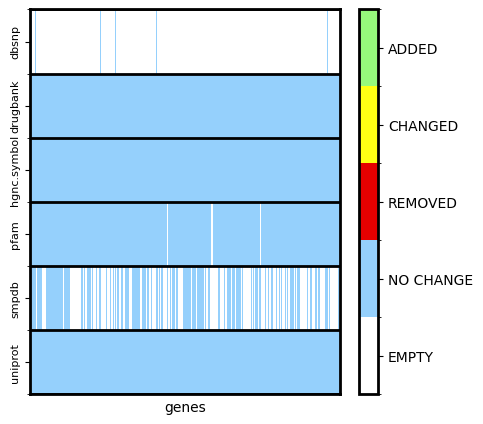

In [13]:
rename_mapping = {
    "drugbank-id": "drugbank",
    "proteins.polypeptide.uniprot-id": "uniprot",
    "proteins.polypeptide.pfams": "pfam",
    "proteins.polypeptide.gene-name": "hgnc.symbol",
    "gene-symbol": "hgnc.symbol",
    "drugbank-id": "drugbank",
    "uniprot-id": "uniprot",
    "rs-id": "dbsnp",
    "drugbank-id": "drugbank",
    "uniprot-id": "uniprot",
    "smpdb-id": "smpdb",
    "ndc-product-code": "ndc",
    "dpd-id": "cdpd",
}
# Start with protein data
df = df_model_drugs_protein_data
df = (
    df.loc[:, [x for x in rename_mapping if x in df.columns]]
    .rename(rename_mapping, axis=1)
    .drop_duplicates()
)
df_annotations = df.drop_duplicates()

# Add SNP data
df = df_model_snp_data
df = (
    df.loc[:, [x for x in rename_mapping if x in df.columns]]
    .rename(rename_mapping, axis=1)
    .drop_duplicates()
)
df_annotations = df_annotations.merge(
    df,
    left_on="uniprot",
    right_on="uniprot",
    suffixes=("", "_drop"),
    how="left",
).drop_duplicates()

# Add Pathway data
df = df_pathways_data
df = (
    df.loc[:, [x for x in rename_mapping if x in df.columns]]
    .rename(rename_mapping, axis=1)
    .drop_duplicates()
)
df_annotations = df_annotations.merge(
    df,
    left_on="uniprot",
    right_on="uniprot",
    suffixes=("", "_drop"),
    how="left",
).drop_duplicates()

# # Add product data
# df = df_products_data
# df = df.loc[:, [x for x in rename_mapping if x in df.columns]].rename(rename_mapping, axis=1).drop_duplicates()
# df_annotations = df_annotations.merge(
#     df,
#     left_on="uniprot",
#     right_on="uniprot",
#     suffixes=("", "_drop"),
#     how="left",
# ).drop_duplicates()


df_annotations = df_annotations.drop(
    labels=[col for col in df_annotations.columns if col.endswith("_drop")], axis=1
).drop_duplicates()
df_annotations = explode_column(df_annotations, "pfam", sep=";")
df_annotations = df_annotations.drop_duplicates().replace("", pd.NA)
df_annotations = (
    df_annotations.groupby("uniprot", as_index=False)
    .agg(lambda x: build_string(sorted(x.dropna().unique())))
    .replace("", pd.NA)
)
df_annotations = pd.merge(
    df_model_mappings[[annotation_type, mapping_key]].drop_duplicates(),
    df_annotations,
    left_on=mapping_key,
    right_on=mapping_key,
    how="left",
)
df_annotations = (
    df_annotations.sort_values("genes")
    .dropna(subset=["drugbank"])
    .reset_index(drop=True)
)

df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{db_tag}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = explode_column(df_annotations, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        f"{annotation_dirpath}/{annotation_type}_{db_tag}.tsv", sep="\t", index=False
    )
else:
    df_annotations.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{db_tag}.tsv",
        sep="\t",
        index=False,
    )
df_annotations